In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import random
import time
from torchvision import transforms, datasets
from torch.utils.data import DataLoader
import PIL 
from tqdm import tqdm
import matplotlib.pyplot as plt
# tsne and pca
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from IPython.display import clear_output
import untils
from COBWEBNN import CobwebNN, CobwebNNTreeLayer, TestModel

In [249]:
import json
# load mnist_tree.json
with open('mnist_tree.json', 'r') as f:
    mnist_tree = json.load(f)
    

FileNotFoundError: [Errno 2] No such file or directory: 'mnist_tree.json'

In [ ]:
import base64
import matplotlib.pyplot as plt
from io import BytesIO
import json

def tensor_to_base64(tensor, shape, cmap="gray", normalize=False):
    array = tensor.numpy().reshape(shape)
    if normalize:
        plt.imshow(array, cmap=cmap, aspect="auto")
    else:
        plt.imshow(array, cmap=cmap, aspect="auto", vmin=0, vmax=1)

    plt.axis("off")

    buf = BytesIO()
    plt.savefig(buf, format="png", bbox_inches="tight", pad_inches=0)
    plt.close()
    
    buf.seek(0)
    return base64.b64encode(buf.getvalue()).decode("utf-8")

In [ ]:
mnist_tree.keys()

dict_keys(['node_id', 'mean', 'count', 'sum_sq', 'children'])

In [ ]:
# change id to node_id, mean to image
# use while loop to traverse the tree

pq = [mnist_tree]

while True:
    # chaneg the key name "id" to "node_id"
    curr = pq.pop(0)
    # curr["node_id"] = curr.pop("id")
    curr["image"] = tensor_to_base64(torch.tensor(curr["mean"]), (28, 28), cmap="inferno", normalize=True)
    # remove the key "mean"
    curr.pop("mean")
    # if the node is leaf node, break the loop
    if "children" not in curr:
        break
    # add the children to the queue
    for child in curr["children"]:
        pq.append(child)

In [ ]:
mnist_tree.keys()
# save the tree to tree_visualization.json
with open('tree_visualization.json', 'w') as f:
    json.dump(mnist_tree, f)

torch.Size([1, 1, 28, 28]) tensor([5])


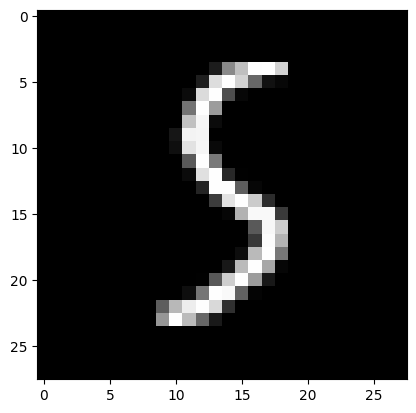

In [4]:
download = False
dataset_class = datasets.MNIST
mnist_transform = [transforms.ToTensor()]
# add normalization to the transform list such that all values are strictly greater than 0
# mnist_transform.append(transforms.Lambda(lambda x: x + 1e-5))
# normalize the data
mnist_transform.append(transforms.Normalize((0.1307,), (0.3081,)))

dataset_transform = transforms.Compose(mnist_transform)
mnist_train = dataset_class('data/MNIST', train=True, download=download, transform=dataset_transform)
mnist_test = dataset_class('data/MNIST', train=False, download=download, transform=dataset_transform)

# mnist_train.data.to('cuda')
# mnist_train.targets.to('cuda')
# # mnist_test.data.to('cuda')
# mnist_test.data.to('cuda')x
# mnist_test.targets.to('cuda')
# mnist_test.labels
# create a dataloader with
#  batch size 1
mnist_train_loader = DataLoader(mnist_train, batch_size=1, shuffle=True)
mnist_test_loader = DataLoader(mnist_test, batch_size=1, shuffle=True)

# test the dataloader
for i, (data, target) in enumerate(mnist_train_loader):
    print(data.shape, target)
    # print(data)
    # display the first image
    plt.imshow(data[0, 0].numpy(), cmap='gray')
    plt.show()
    break

seed = 1
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# randonly shuffle the training data
mnist_train_loader = DataLoader(mnist_train, batch_size=8, shuffle=True)

torch.Size([1, 3, 32, 32]) tensor([8])
tensor([[[[ 1.3764,  1.4240,  1.5034,  ...,  1.3447,  1.3605,  1.3923],
          [ 1.3288,  1.3605,  1.4082,  ...,  1.2494,  1.2653,  1.2811],
          [ 1.3605,  1.3764,  1.4240,  ...,  1.2335,  1.2653,  1.2653],
          ...,
          [ 0.9795,  0.9477, -0.3224,  ...,  1.6622,  1.7098,  1.7257],
          [ 1.0747,  1.0747,  0.9001,  ...,  1.7098,  1.7416,  1.8051],
          [ 1.4875,  1.4875,  1.5352,  ...,  1.7575,  1.8051,  1.8368]],

         [[ 1.5822,  1.6144,  1.6629,  ...,  1.5338,  1.5660,  1.5983],
          [ 1.5338,  1.5338,  1.5660,  ...,  1.4369,  1.4531,  1.4853],
          [ 1.5499,  1.5499,  1.5660,  ...,  1.4208,  1.4531,  1.4369],
          ...,
          [ 1.0819,  0.8560, -0.6933,  ...,  1.7274,  1.7920,  1.8242],
          [ 1.1142,  1.0980,  0.8882,  ...,  1.7758,  1.8081,  1.8888],
          [ 1.5499,  1.5822,  1.6467,  ...,  1.8727,  1.9372,  2.0018]],

         [[ 1.6399,  1.6699,  1.7300,  ...,  1.5948,  1.5948,  

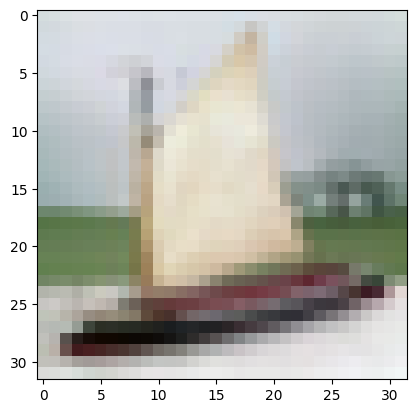

In [5]:
# load CIFAR10
download = False
dataset_class = datasets.CIFAR10
cifar10_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.4914, 0.4822, 0.4465], 
                         std=[0.247, 0.243, 0.261])
])

# dataset_transform = transforms.Compose(cifar10_transform)
cifar10_train = dataset_class('data/CIFAR10', train=True, download=download, transform=cifar10_transform)
cifar10_test = dataset_class('data/CIFAR10', train=False, download=download, transform=cifar10_transform)

cifar10_train_loader = DataLoader(cifar10_train, batch_size=1, shuffle=True)
cifar10_test_loader = DataLoader(cifar10_test, batch_size=1, shuffle=True)

# test the dataloader
for i, (data, target) in enumerate(cifar10_train_loader):
    print(data.shape, target)
    print(data)
    # display the first image
    d = data[0].permute(1, 2, 0).numpy()
    # denomalrize
    d = d * [0.247, 0.243, 0.261] + [0.4914, 0.4822, 0.4465]
    plt.imshow(d)
    plt.show()
    break

In [ ]:
n_clusters = 2 # output cluster
leaves = nn.Parameter(torch.randn(4, 4))
print(leaves)
cluster_weight = nn.Parameter(torch.randn(n_clusters, 1))
sigmoid = nn.Sigmoid()
alpha = sigmoid(cluster_weight)
alpha = torch.cat((alpha, 1-alpha), dim=1).unsqueeze(-1)
print(alpha)

# mean_root = leaves * alpha
mean_root = leaves.view(-1, 2, 4) * alpha
print(mean_root.sum(dim=1))
# mean_root = mean_root.view(-1, 2, 4).sum(dim=1)
# mean_root

Parameter containing:
tensor([[ 1.3851, -0.8138, -0.9276,  1.1120],
        [ 0.6155,  0.1938, -2.5832,  0.8539],
        [-2.1021, -0.6200, -1.4782, -1.1334],
        [-0.1010,  0.3434, -1.0703, -0.8743]], requires_grad=True)
tensor([[[0.5932],
         [0.4068]],

        [[0.4299],
         [0.5701]]], grad_fn=<UnsqueezeBackward0>)
tensor([[ 1.0721, -0.4040, -1.6010,  1.0070],
        [-0.9612, -0.0708, -1.2456, -0.9857]], grad_fn=<SumBackward1>)


In [ ]:
def loss_fn(x, means, logvars, sampled, p_x_nodes):
    pass

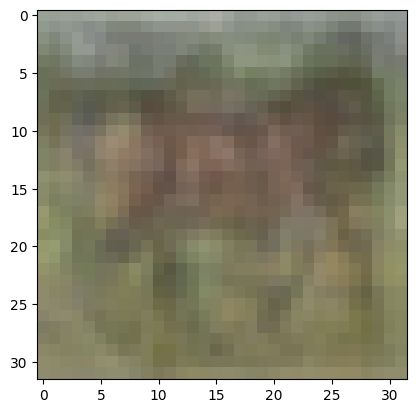

In [23]:
# plot the average of class 0 from CIFAR10
# get the mean of class 0
cifar10_class0 = []
for i, (data, target) in enumerate(cifar10_train_loader):
    if target == 7:
        cifar10_class0.append(data)
    if len(cifar10_class0) == 10:
        break

cifar10_class0 = torch.cat(cifar10_class0)

# plot the average of class 0
    # d = d * [0.247, 0.243, 0.261] + [0.4914, 0.4822, 0.4465]

plt.imshow(cifar10_class0.mean(dim=0).permute(1, 2, 0).numpy()) #* [0.247, 0.243, 0.261] + [0.4914, 0.4822, 0.4465])
plt.show()

In [6]:
# only 1 and 0
hard = [4,5,7,9]
super_easy = [3, 5]
easy = [0,1,2,3]
longer = [0,1,2,3,4,5,6,7]
random_digit = [1, 4, 6, 8]
all_labels = list(range(10))

split = all_labels

mnist_01_train = untils.filter_by_label(cifar10_train, split, rename_labels=True)
mnist_01_test = untils.filter_by_label(cifar10_test, split, rename_labels=True)

100%|██████████| 10000/10000 [00:00<00:00, 26150.01it/s]


100%|██████████| 391/391 [00:36<00:00, 10.58it/s]


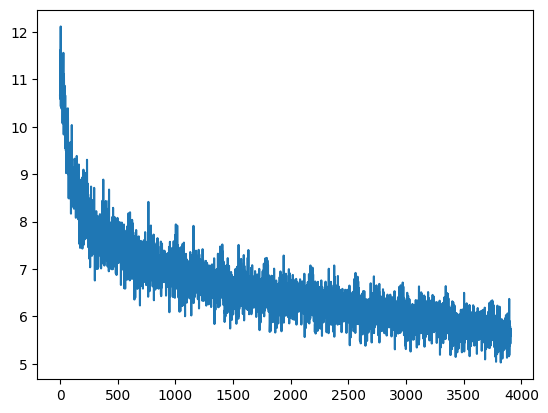

In [7]:
import untils
from COBWEBNN import CobwebNN, CobwebNNTreeLayer, TestModel
n_layers = 10
image_shape = (3, 32, 32)
image_shape_prod = image_shape[0] * image_shape[1] * image_shape[2]
cobweb = CobwebNN(image_shape=image_shape, n_layers=n_layers, n_hidden=256)

cobweb.to('mps')
optimizer = optim.Adam(cobweb.parameters(), lr=1e-3)
train_loader = DataLoader(mnist_01_train, batch_size=128, shuffle=False)

all_losses = []

epochs = 10
for _ in range(epochs):
    for j, (data, target) in enumerate(tqdm(train_loader)):
        optimizer.zero_grad()

        data = data.to('mps')
        x, means, logvars, x_preds, p_x_nodes, p_node_xs = cobweb(data)
        loss = 0
        # break
        H = 0
        for i, (mean, logvar, x_pred, p_x_node, p_node_x) in enumerate(zip(means, logvars, x_preds, p_x_nodes, p_node_xs)):
            # print(x_pred.shape, data.shape)
            # print(x_pred.shape, data.shape)
            # REC = F.mse_loss(x_pred, data.view(-1, 28*28))
            # MSE betwwen two images
            REC = F.mse_loss(x_pred.view(-1, image_shape_prod), data.view(-1, image_shape_prod))
            KL = untils.cross_entropy_regularization(p_node_x, depth=n_layers - i, lambda_=100)
            LOG_PROB = -p_x_node.sum(dim=-1).mean()
            # if LOG_PROB < 0:
            #     assert False
            # print(REC, KL)
            # break
            # print(p_x_node)
            # print(KL)
            # KLD between q(z|x) and p(z)
            KLD = -0.5 * torch.sum(1 + logvar - mean.pow(2) - logvar.exp())
            if i == 0: # leaf level
                # some of entropy of leaf nodes
                H = torch.sum(0.5 * (torch.log(2 * torch.tensor(torch.pi)) + logvar) + 0.5)
                # print(H)
            # if i == n_layers - 1: # root level
                # H -= torch.sum(0.5 * (torch.log(2 * torch.tensor(torch.pi)) + logvar) + 0.5)
            # print(H)
            loss += REC# + KL
        # loss += H * 0.02


            # print(KLD.item(), REC.item())
            # break
        # print(loss.item())

        loss.backward()
        optimizer.step()
        all_losses.append(loss.item())

        # if j == 1:
        #     break



        # break
        # output.loss.backward()
        # optimizer.step()
        # if i % 100 == 0:
            # print(f"Epoch {_} Iter {i} Loss: {output.loss.item()}")

plt.plot(all_losses)
# untils.viz_prototypes(cobweb)

In [ ]:
untils.viz_prototypes(cobweb, shape=image_shape, conved_shape=(cobweb.out_channels, cobweb.H_conv, cobweb.W_conv))
# untils.viz_batch_reconstruction(cobweb, mnist_01_test, device='mps')
# untils.viz_sampled_x(cobweb, mnist_01_test, device='mps')

In [11]:
untils.model_forzen_classification(cobweb, mnist_01_train, mnist_01_test, device='mps', batch_size=128)

100%|██████████| 79/79 [00:00<00:00, 413.65it/s]

Accuracy: 0.3507


0.3507

torch.Size([1000, 64, 6, 6])


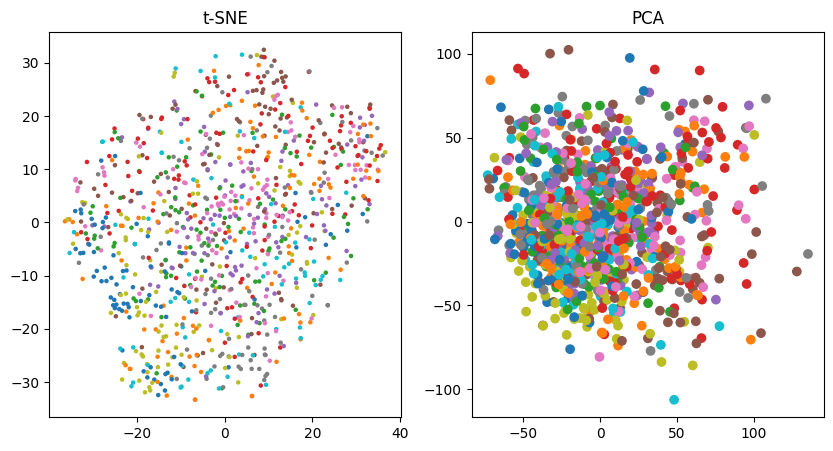

In [10]:
untils.viz_clusters(cobweb, mnist_01_test, device='mps', n_data=1000)

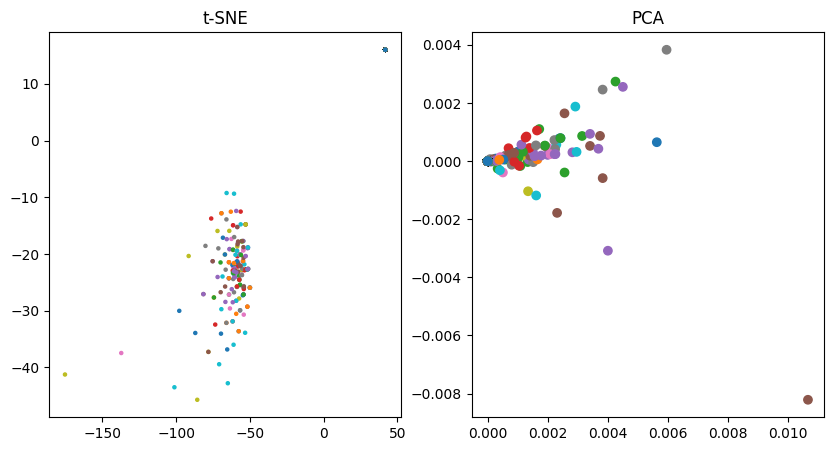

In [33]:
untils.viz_clusters(cobweb, mnist_01_test, device='mps', n_data=500)

In [82]:
# get leaves
leaves = cobweb.leaves.detach()
logvars = cobweb.leaves_logvar.detach()

test_loader = DataLoader(mnist_01_test, batch_size=128, shuffle=False)
for test_image, target in test_loader:
    # encode image
    with torch.no_grad():
        latent = cobweb.mu(cobweb.fc(test_image.view(-1, image_shape_prod).to('mps')))
        # calculate the distance between the latent and the leaves
        # print(latent.shape, leaves.shape)
        dist = torch.norm(latent.unsqueeze(1) - leaves, p=2, dim=-1)
        probs = F.softmax(-dist, dim=-1)
        # print(probs.shape)
        pred = probs.argmax(dim=-1).cpu()

        # change target mapping: 0 -> 0, 1 -> 2, 2 -> 3, 3 -> 1
        target = target.cpu()
        target = torch.tensor([3 if t == 0 else 1 if t == 1 else 0 if t == 2 else 2 for t in target])

        correct = (pred == target).sum().item()
        print(correct)

        break

39


In [299]:
import torch
import os
# Add Graphviz's bin directory to the PATH.
os.environ["PATH"] += os.pathsep + "/opt/homebrew/bin"
from torchviz import make_dot
# model = CobwebNN(n_hidden=784, n_layers=4, imprint_dim=10)
model = CobwebNN(image_shape=(3, 32, 32), n_layers=n_layers, n_hidden=32)
x = torch.randn(5, 3, 32, 32)
y = torch.randn(5, 3, 32, 32)

x, means, logvars, x_preds, p_x_nodes, p_node_xs = model(x)
loss = 0
for i, (mean, logvar, x_pred, p_x_node, p_node_x) in enumerate(zip(means, logvars, x_preds, p_x_nodes, p_node_xs)):
    loss += F.mse_loss(x_pred.view(-1, 3*32*32), y.view(-1, 3*32*32))

dot = make_dot(loss, params=dict(model.named_parameters()))
dot.render("compute_graph", format="pdf")

'compute_graph.pdf'

cluster_weight: [[0.6906636]]


/var/folders/20/sbb3zm0s7t93v_80z1k489v00000gp/T/ipykernel_35710/1089314447.py:5: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  right_mean = (root_mean - cluster_weight * left_mean) / (1 - cluster_weight)


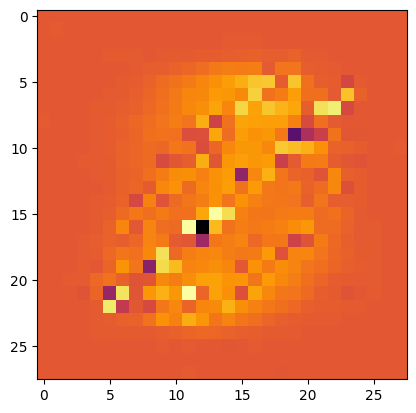

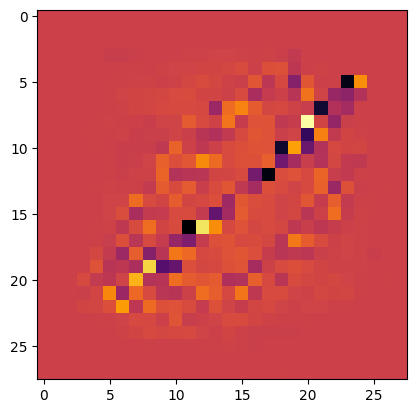

In [ ]:
# print left and right mean
left_mean = cobwebNN.layers[0].mean_l.cpu().detach().numpy()
cluster_weight = F.sigmoid(cobwebNN.layers[0].cluster_weight.cpu().detach()).numpy()
print(f"cluster_weight: {cluster_weight}")
right_mean = (root_mean - cluster_weight * left_mean) / (1 - cluster_weight) 

# display the first image
plt.imshow(left_mean.reshape(-1, 28), cmap='inferno')
plt.show()
plt.imshow(right_mean.reshape(-1, 28), cmap='inferno')
plt.show()

Epoch 10/10: 100%|██████████| 774/774 [00:01<00:00, 609.07it/s, loss=0.0467]


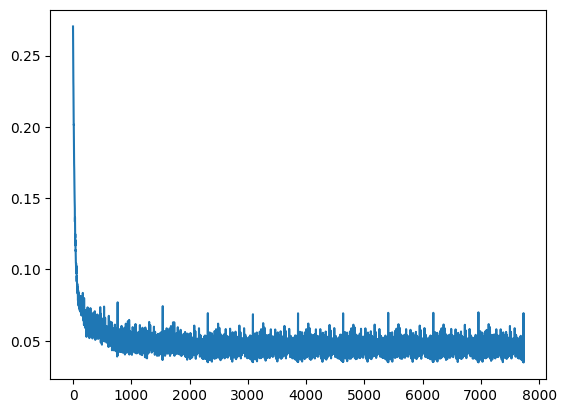

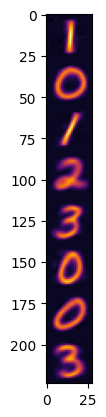

In [ ]:
test_model = TestModel()

test_model.to('mps')
optimizer = optim.Adam(test_model.parameters(), lr=1e-2)

untils.train_model(test_model, mnist_01_train, True, optimizer, epochs=10, hard=True, batch_size=32, show_loss=True, 
                   device='mps', verbose=False, early_break=False)

# print left and right mean
chidlren_mean = test_model.children_mean.detach().cpu().numpy()
# display the first image
plt.imshow(chidlren_mean.reshape(-1, 28), cmap='inferno')
plt.show()
# plt.imshow(chidlren_mean[1].reshape(28, 28), cmap='inferno')
# plt.show()


/var/folders/20/sbb3zm0s7t93v_80z1k489v00000gp/T/ipykernel_31960/1151203458.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  l1_split = torch.tensor(l1_split > 0.5, dtype=torch.float32)


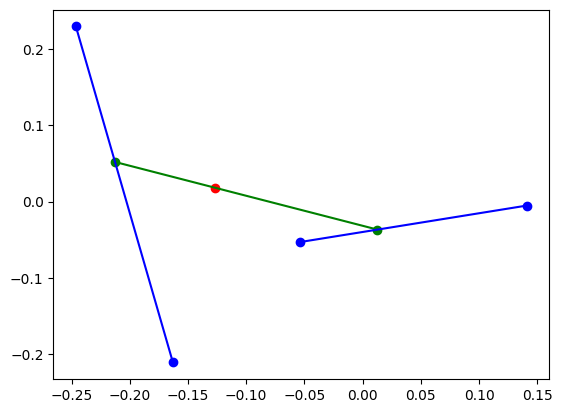

In [ ]:
# random 2d data
n = 100
data = torch.randn(n, 2)
l1_split = torch.rand(n)
l1_split = torch.tensor(l1_split > 0.5, dtype=torch.float32)
data_l1_left = data[l1_split == 1]
data_l1_right = data[l1_split == 0]

l2_split_left = torch.rand(data_l1_left.size(0)) > 0.5
l2_split_right = torch.rand(data_l1_right.size(0)) > 0.5
data_l2_left_left = data_l1_left[l2_split_left]
data_l2_left_right = data_l1_left[~l2_split_left]

data_l2_right_left = data_l1_right[l2_split_right]
data_l2_right_right = data_l1_right[~l2_split_right]

# plot centorids
data_mean = data.mean(dim=0)
mean_l1_left = data_l1_left.mean(dim=0)
mean_l1_right = data_l1_right.mean(dim=0)
mean_l2_left_left = data_l2_left_left.mean(dim=0)
mean_l2_left_right = data_l2_left_right.mean(dim=0)
mean_l2_right_left = data_l2_right_left.mean(dim=0)
mean_l2_right_right = data_l2_right_right.mean(dim=0)

# plot the means
# plt.scatter(data[:, 0], data[:, 1])
plt.scatter(data_mean[0], data_mean[1], c='r')
plt.scatter(mean_l1_left[0], mean_l1_left[1], c='g')
plt.scatter(mean_l1_right[0], mean_l1_right[1], c='g')
# connect these two means
plt.plot([mean_l1_right[0], mean_l1_left[0]], [mean_l1_right[1], mean_l1_left[1]], c='g')

plt.scatter(mean_l2_left_left[0], mean_l2_left_left[1], c='b')
plt.scatter(mean_l2_left_right[0], mean_l2_left_right[1], c='b')
# connect these two means
plt.plot([mean_l2_left_left[0], mean_l2_left_right[0]], [mean_l2_left_left[1], mean_l2_left_right[1]], c='b')

plt.scatter(mean_l2_right_left[0], mean_l2_right_left[1], c='b')
plt.scatter(mean_l2_right_right[0], mean_l2_right_right[1], c='b')
# connect these two means
plt.plot([mean_l2_right_left[0], mean_l2_right_right[0]], [mean_l2_right_left[1], mean_l2_right_right[1]], c='b')


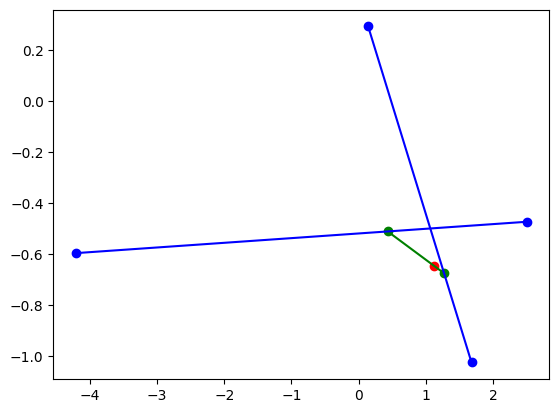

In [ ]:
root_mean = torch.randn(2)
left_mean = torch.randn(2)
l1_alpha = torch.rand(1)
right_mean = (root_mean - l1_alpha * left_mean) / (1 - l1_alpha)

left_left_mean = torch.randn(2)
left_alpha = torch.rand(1)
left_right_mean = (left_mean - left_alpha * left_left_mean) / (1 - left_alpha)

right_left_mean = torch.randn(2)
right_alpha = torch.rand(1)
right_right_mean = (right_mean - right_alpha * right_left_mean) / (1 - right_alpha)

# plot the means
plt.scatter(root_mean[0], root_mean[1], c='r')

plt.scatter(left_mean[0], left_mean[1], c='g')
plt.scatter(right_mean[0], right_mean[1], c='g')
# connect these two means
plt.plot([right_mean[0], left_mean[0]], [right_mean[1], left_mean[1]], c='g')

plt.scatter(left_left_mean[0], left_left_mean[1], c='b')
plt.scatter(left_right_mean[0], left_right_mean[1], c='b')
# connect these two means
plt.plot([left_left_mean[0], left_right_mean[0]], [left_left_mean[1], left_right_mean[1]], c='b')

plt.scatter(right_left_mean[0], right_left_mean[1], c='b')
plt.scatter(right_right_mean[0], right_right_mean[1], c='b')
# connect these two means
plt.plot([right_left_mean[0], right_right_mean[0]], [right_left_mean[1], right_right_mean[1]], c='b')
